In [8]:
import json
import csv
from collections import defaultdict
from tqdm import tqdm

# 文件路径
json_file_path = '/data1/dxw_data/llm/redbook_final/script_next/umap095_cluster_imagebind3/labels.json'
csv_file_path = '/data1/dxw_data/llm/redbook_final/script_next/matching_records.csv'
output_file_path = '/data1/dxw_data/llm/redbook_final/script_next/umap095_cluster_imagebind3/image_output.csv'

# Step 1: 读取 JSON 文件
with open(json_file_path, 'r') as file:
    labels_data = json.load(file)

# Step 2: 读取 CSV 文件
matching_records = {}
with open(csv_file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # 以 poster_id 和 post_id 的组合为 key 存储记录
        key = f"{row['poster_id']}_{row['post_id']}"
        # 提取出 "MM-DD" 格式的日期
        date = row['post_date'][:5]  # "MM-DD"
        matching_records[key] = date

# Step 3: 初始化统计字典
monthly_category_count = defaultdict(lambda: defaultdict(int))
monthly_total_count = defaultdict(int)

# Step 4: 处理 JSON 数据并进行统计
output_data = []
for file_name, category in tqdm(labels_data.items(), desc="Processing Records"):
    # 提取 poster_id 和 post_id
    prefix = file_name.split('_image_embedding.pt')[0]
    ids = prefix.split('_')
    
    # Assuming poster_id and post_id are always the last two parts
    if len(ids) >= 2:
        poster_id, post_id = ids[-2], ids[-1]
        key = f"{poster_id}_{post_id}"
        
        # 在匹配的 CSV 中查找对应的日期信息
        if key in matching_records:
            date = matching_records[key]
            month = date.split('-')[0]  # 从日期中提取月份信息
            
            # 更新统计计数
            monthly_category_count[month][category] += 1
            monthly_total_count[month] += 1
        else:
            print(f"Warning: No matching record found for {key}. Skipping.")
    else:
        print(f"Warning: Unexpected file name format {file_name}. Skipping.")

# Step 5: 计算比例并准备输出数据
for month, category_count in monthly_category_count.items():
    total_images = monthly_total_count[month]
    for category, count in category_count.items():
        proportion = count / total_images if total_images > 0 else 0
        output_data.append({
            'month': month,
            'nums_category_img': category,
            'count': count,
            'all': total_images,
            'proportion': round(proportion, 4)
        })

# Step 6: 将结果写入 CSV 文件
with open(output_file_path, 'w', newline='') as csvfile:
    fieldnames = ['month', 'nums_category_img', 'count', 'all', 'proportion']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in output_data:
        writer.writerow(row)

print(f"Data has been successfully written to {output_file_path}")


Processing Records: 100%|██████████| 5912/5912 [00:00<00:00, 616972.09it/s]

Data has been successfully written to /data1/dxw_data/llm/redbook_final/script_next/umap095_cluster_imagebind3/image_output.csv


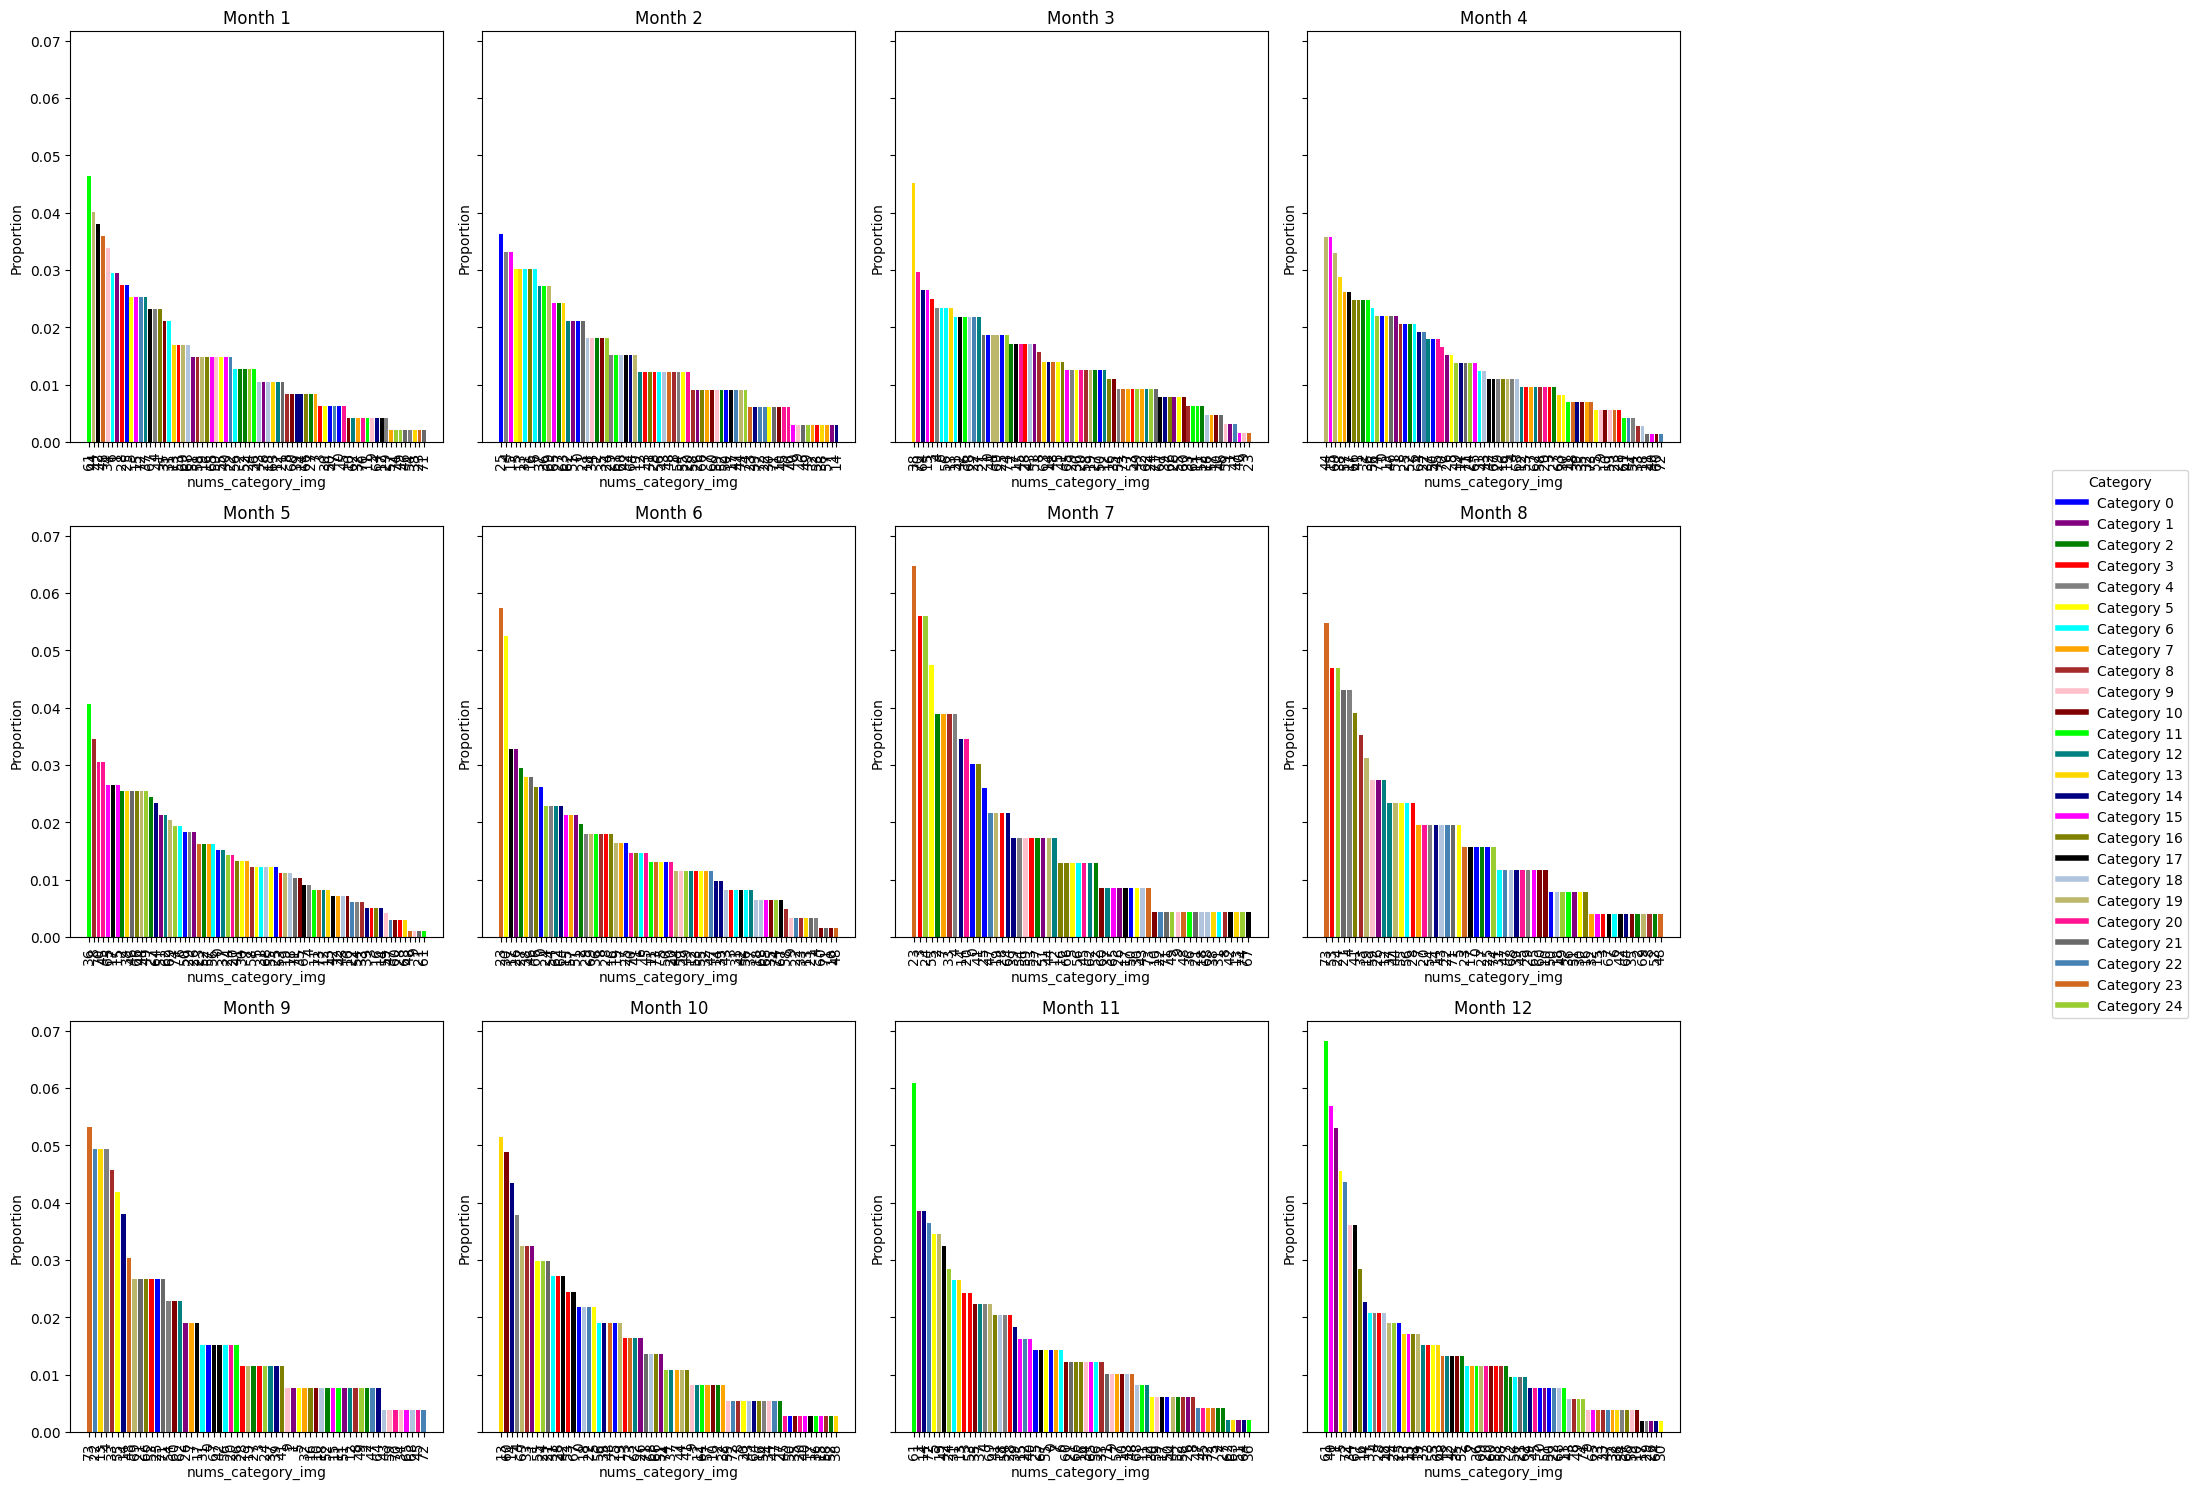

Top 5 categories for each month saved to 'top5_categories_per_month.json'


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# 读取数据
file_path = '/data1/dxw_data/llm/redbook_final/script_next/umap095_cluster_imagebind3/image_output.csv'
data = pd.read_csv(file_path)

# 预定义25种差别很大的颜色
colors = [
    '#0000FF', '#800080', '#008000', '#FF0000', '#808080', '#FFFF00',
    '#00FFFF', '#FFA500', '#A52A2A', '#FFC0CB', '#800000', '#00FF00',
    '#008080', '#FFD700', '#000080', '#FF00FF', '#808000', '#000000',
    '#B0C4DE', '#BDB76B', '#FF1493', '#696969', '#4682B4', '#D2691E',
    '#9ACD32'
]

# 创建一个字典来保存每个月的top5分类
top5_categories = {}

# 设置画布和子图
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True)
axes = axes.flatten()

# 绘制每个月的柱状图
for month in range(1, 13):
    ax = axes[month-1]
    monthly_data = data[data['month'] == month]
    sorted_data = monthly_data.sort_values(by='proportion', ascending=False)
    
    # 提取top5的分类
    top5 = sorted_data.head(5)
    top5_categories[month] = top5['nums_category_img'].tolist()
    
    bars = ax.bar(range(len(sorted_data)), sorted_data['proportion'], color=[colors[i % 25] for i in sorted_data['nums_category_img']])
    
    ax.set_title(f'Month {month}')
    ax.set_xticks(range(len(sorted_data)))
    ax.set_xticklabels(sorted_data['nums_category_img'], rotation=90)
    ax.set_xlabel('nums_category_img')
    ax.set_ylabel('Proportion')

# 添加图例
handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(25)]
labels = [f'Category {i}' for i in range(25)]
fig.legend(handles, labels, loc='center right', title='Category', bbox_to_anchor=(1.1, 0.5))

# 调整布局
plt.tight_layout(rect=[0, 0, 0.85, 1])

# 保存图片
plt.savefig('monthly_category_proportions-image2.png')
plt.show()

# 将top5分类保存为JSON格式
with open('top5_categories_per_month-image2.json', 'w') as json_file:
    json.dump(top5_categories, json_file, indent=4)

print("Top 5 categories for each month saved to 'top5_categories_per_month.json'")


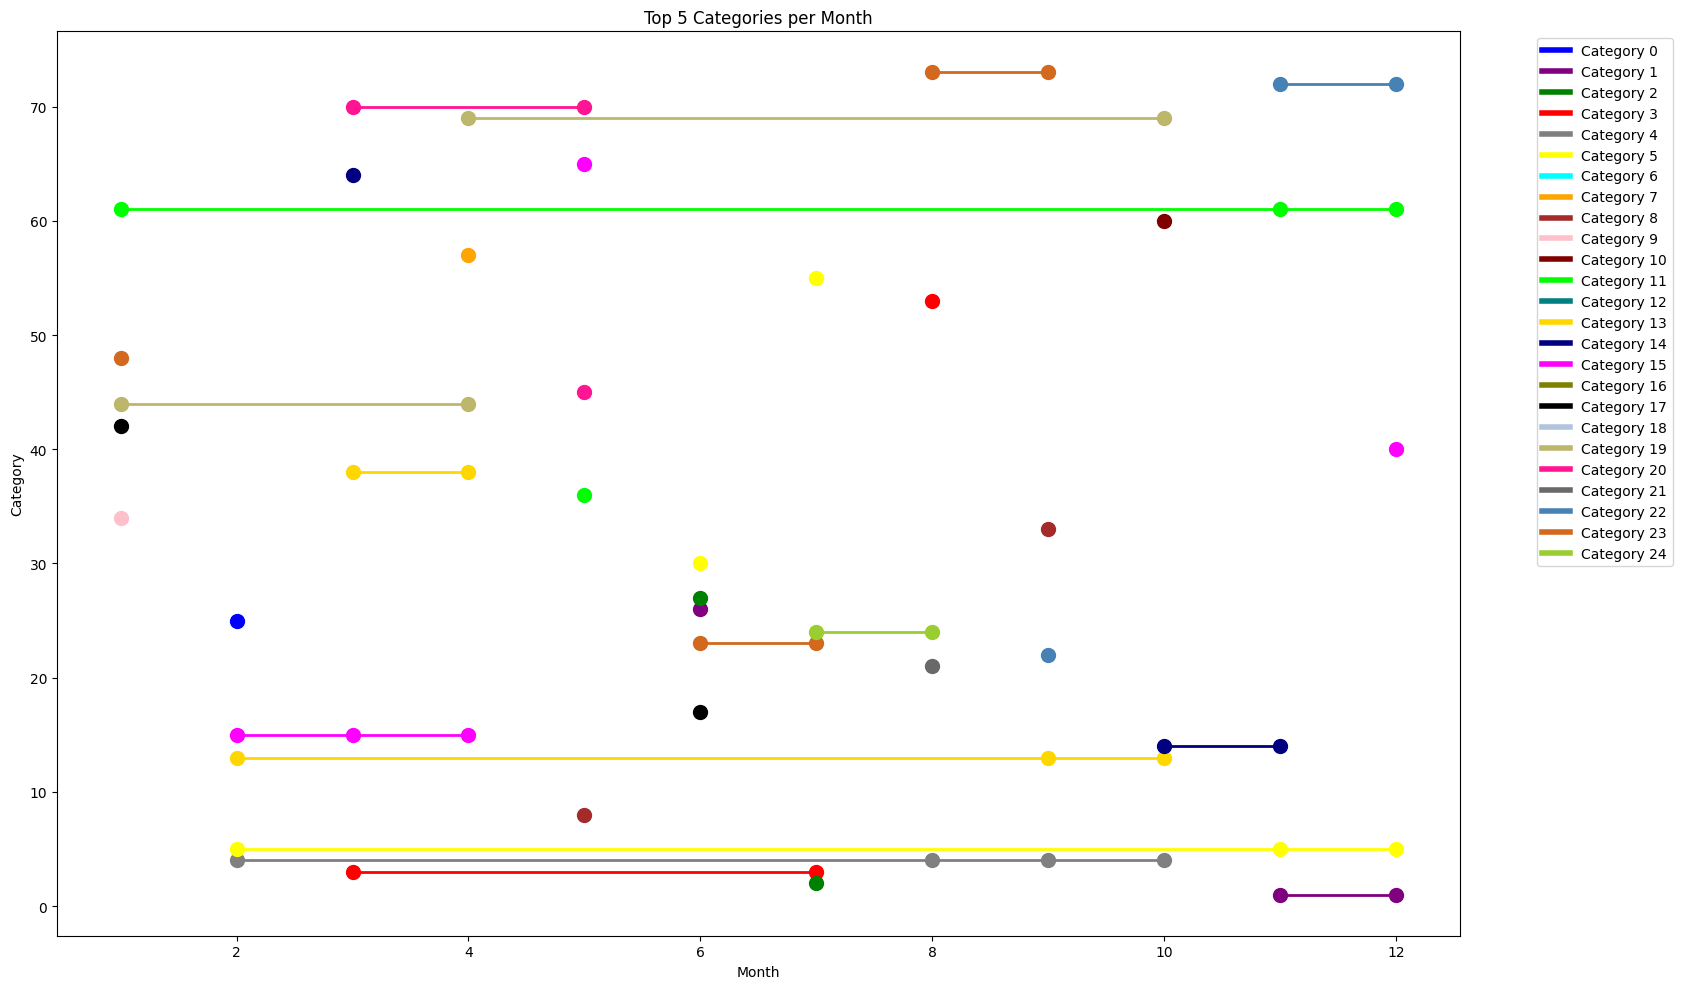

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# 读取JSON文件
json_file_path = '/data1/dxw_data/llm/Multimodal-MKT/label/multimodal-cluster/top5_categories_per_month-image2.json'
with open(json_file_path, 'r') as f:
    top5_categories_per_month = json.load(f)

# 预定义25种差别很大的颜色
colors = [
    '#0000FF', '#800080', '#008000', '#FF0000', '#808080', '#FFFF00',
    '#00FFFF', '#FFA500', '#A52A2A', '#FFC0CB', '#800000', '#00FF00',
    '#008080', '#FFD700', '#000080', '#FF00FF', '#808000', '#000000',
    '#B0C4DE', '#BDB76B', '#FF1493', '#696969', '#4682B4', '#D2691E',
    '#9ACD32'
]

# 创建图表
plt.figure(figsize=(20, 10))

# 为每个类别初始化一个空列表，存储每个月的比例
category_positions = {category: [] for category in range(100)}

# 绘制每个月的top5 category
for month in range(1, 13):
    top5_categories = top5_categories_per_month[str(month)]
    
    # 绘制每个top5类别的点
    for category in top5_categories:
        category_positions[category].append(month)
        # 绘制点
        plt.scatter(month, category, color=colors[category % 25], s=100, zorder=5)

# 绘制连线
for category, positions in category_positions.items():
    if len(positions) > 1:
        plt.plot(positions, [category] * len(positions), color=colors[category % 25], linestyle='-', linewidth=2, zorder=3)

# 设置图表标题和标签
plt.title('Top 5 Categories per Month')
plt.xlabel('Month')
plt.ylabel('Category')

# 设置图例
handles = [plt.Line2D([0], [0], color=colors[i % 25], lw=4) for i in range(25)]
labels = [f'Category {i}' for i in range(25)]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整布局并保存图片
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('top5_categories_line_plot-umap.png')
plt.show()


In [20]:
import os
import json
import random
from PIL import Image

# Constants
input_base_path = '/data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3'
replacement_base_path = '/data1/dxw_data/llm/redbook_final/script_next/data_img_20%'
output_base_path = '/data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap-top12'
json_file_path = '/data1/dxw_data/llm/Multimodal-MKT/label/multimodal-cluster/top5_categories_per_month-image2.json'

# Ensure the output directory exists
os.makedirs(output_base_path, exist_ok=True)

# Load the top 5 categories per month from the JSON file
with open(json_file_path, 'r') as f:
    top5_categories_per_month = json.load(f)

# Function to sample images from a category folder
def sample_images_from_category(category, sample_size=10):
    category_path = os.path.join(input_base_path, str(category))
    image_files = [f for f in os.listdir(category_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sampled_files = random.sample(image_files, min(sample_size, len(image_files)))
    return sampled_files

# Function to replace sampled images with corresponding images from another directory
def replace_with_processed_images(sampled_files):
    replaced_images = []
    for file in sampled_files:
        replacement_image_path = os.path.join(replacement_base_path, file)
        if os.path.exists(replacement_image_path):
            replaced_images.append(replacement_image_path)
        else:
            print(f"Replacement image not found for {file}")
    return replaced_images

# Function to create a composite image for a given month's top categories
def create_monthly_composite_image(month, top_categories):
    images_per_row = 10
    image_width, image_height = 100, 100  # Image size for each thumbnail
    rows = len(top_categories)
    
    # Create a new blank image for the composite
    composite_image = Image.new('RGB', (image_width * images_per_row, image_height * rows), color=(255, 255, 255))

    for row_index, category in enumerate(top_categories):
        sampled_images = sample_images_from_category(category, sample_size=images_per_row)
        processed_images = replace_with_processed_images(sampled_images)
        
        for col_index, image_path in enumerate(processed_images):
            try:
                with Image.open(image_path) as img:
                    # Resize and paste the image into the composite image
                    img = img.resize((image_width, image_height))
                    composite_image.paste(img, (col_index * image_width, row_index * image_height))
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    # Save the composite image
    output_file_path = os.path.join(output_base_path, f'month_{month}_top5.png')
    composite_image.save(output_file_path)
    print(f"Saved composite image for month {month} to {output_file_path}")

# Create and save composite images for each month
for month_str, top_categories in top5_categories_per_month.items():
    month = int(month_str)
    create_monthly_composite_image(month, top_categories)


Saved composite image for month 1 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap-top12/month_1_top5.png
Saved composite image for month 2 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap-top12/month_2_top5.png
Saved composite image for month 3 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap-top12/month_3_top5.png
Saved composite image for month 4 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap-top12/month_4_top5.png
Saved composite image for month 5 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap-top12/month_5_top5.png
Saved composite image for month 6 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap-top12/month_6_top5.png
Saved composite image for month 7 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap-top12/month_7_top5.png
Saved composite image for month 8 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap-top12/month_8_top5.png
Saved composite image for month 9 to /data1/dxw_

In [21]:
import os
import json
import random
from PIL import Image

# Constants
input_base_path = '/data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3'
replacement_base_path = '/data1/dxw_data/llm/redbook_final/script_next/data_img_20%'
output_base_path = '/data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap2-top12'
json_file_path = '/data1/dxw_data/llm/Multimodal-MKT/label/multimodal-cluster/top5_categories_per_month-image2.json'

# Ensure the output directory exists
os.makedirs(output_base_path, exist_ok=True)

# Load the top 5 categories per month from the JSON file
with open(json_file_path, 'r') as f:
    top5_categories_per_month = json.load(f)

# Function to sample images from a category folder
def sample_images_from_category(category, sample_size=10):
    category_path = os.path.join(input_base_path, str(category))
    image_files = [f for f in os.listdir(category_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sampled_files = random.sample(image_files, min(sample_size, len(image_files)))
    return sampled_files, image_files  # Return all images as well for fallback

# Function to replace sampled images with corresponding images from another directory
def replace_with_processed_images(sampled_files, all_files, sample_size=10):
    replaced_images = []
    missing_files = []

    for file in sampled_files:
        replacement_image_path = os.path.join(replacement_base_path, file)
        if os.path.exists(replacement_image_path):
            replaced_images.append(replacement_image_path)
        else:
            missing_files.append(file)  # Track missing files

    # If there are missing files, try to replace them with other images from the category
    while len(replaced_images) < sample_size and all_files:
        additional_file = random.choice(all_files)
        all_files.remove(additional_file)  # Remove to prevent re-selection
        replacement_image_path = os.path.join(replacement_base_path, additional_file)
        if os.path.exists(replacement_image_path):
            replaced_images.append(replacement_image_path)
    
    return replaced_images

# Function to create a composite image for a given month's top categories
def create_monthly_composite_image(month, top_categories):
    images_per_row = 10
    image_width, image_height = 100, 100  # Image size for each thumbnail
    rows = len(top_categories)
    
    # Create a new blank image for the composite
    composite_image = Image.new('RGB', (image_width * images_per_row, image_height * rows), color=(255, 255, 255))

    for row_index, category in enumerate(top_categories):
        sampled_images, all_images = sample_images_from_category(category, sample_size=images_per_row)
        processed_images = replace_with_processed_images(sampled_images, all_images, sample_size=images_per_row)
        
        for col_index, image_path in enumerate(processed_images):
            try:
                with Image.open(image_path) as img:
                    # Resize and paste the image into the composite image
                    img = img.resize((image_width, image_height))
                    composite_image.paste(img, (col_index * image_width, row_index * image_height))
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    # Save the composite image
    output_file_path = os.path.join(output_base_path, f'month_{month}_top5.png')
    composite_image.save(output_file_path)
    print(f"Saved composite image for month {month} to {output_file_path}")

# Create and save composite images for each month
for month_str, top_categories in top5_categories_per_month.items():
    month = int(month_str)
    create_monthly_composite_image(month, top_categories)


Saved composite image for month 1 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap2-top12/month_1_top5.png
Saved composite image for month 2 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap2-top12/month_2_top5.png
Saved composite image for month 3 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap2-top12/month_3_top5.png
Saved composite image for month 4 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap2-top12/month_4_top5.png
Saved composite image for month 5 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap2-top12/month_5_top5.png
Saved composite image for month 6 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap2-top12/month_6_top5.png
Saved composite image for month 7 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap2-top12/month_7_top5.png
Saved composite image for month 8 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap2-top12/month_8_top5.png
Saved composite image for month 9 to /da

In [23]:
import os
import json
import random
from PIL import Image

# Constants
input_base_path = '/data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3'
replacement_base_path = '/data1/dxw_data/llm/redbook_final/script_next/data_img_20%'
output_base_path = '/data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap3-top12'
json_file_path = '/data1/dxw_data/llm/Multimodal-MKT/label/multimodal-cluster/top5_categories_per_month-image2.json'

# Ensure the output directory exists
os.makedirs(output_base_path, exist_ok=True)

# Load the top 5 categories per month from the JSON file
with open(json_file_path, 'r') as f:
    top5_categories_per_month = json.load(f)

# Function to sample images from a category folder
def sample_images_from_category(category, sample_size=10):
    category_path = os.path.join(input_base_path, str(category))
    image_files = [f for f in os.listdir(category_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sampled_files = random.sample(image_files, min(sample_size, len(image_files)))
    return sampled_files, image_files  # Return all images as well for fallback

# Function to replace sampled images with corresponding images from another directory
def replace_with_processed_images(sampled_files, all_files, sample_size=10):
    replaced_images = []
    missing_files = []

    for file in sampled_files:
        replacement_image_path = os.path.join(replacement_base_path, file)
        if os.path.exists(replacement_image_path):
            replaced_images.append(replacement_image_path)
        else:
            missing_files.append(file)  # Track missing files

    # If there are missing files, try to replace them with other images from the category
    while len(replaced_images) < sample_size and all_files:
        additional_file = random.choice(all_files)
        all_files.remove(additional_file)  # Remove to prevent re-selection
        replacement_image_path = os.path.join(replacement_base_path, additional_file)
        if os.path.exists(replacement_image_path):
            replaced_images.append(replacement_image_path)
    
    return replaced_images

# Function to create a composite image for a given month's top categories
def create_monthly_composite_image(month, top_categories):
    images_per_row = 10
    image_width, image_height = 100, 100  # Image size for each thumbnail
    max_rows = 3  # We only want to keep the first 3 non-empty rows
    
    # Create a new blank image for the composite
    composite_image = Image.new('RGB', (image_width * images_per_row, image_height * max_rows), color=(255, 255, 255))

    current_row = 0
    for row_index, category in enumerate(top_categories):
        if current_row >= max_rows:
            break
        
        sampled_images, all_images = sample_images_from_category(category, sample_size=images_per_row)
        processed_images = replace_with_processed_images(sampled_images, all_images, sample_size=images_per_row)
        
        if processed_images:  # Only add this row if it's not empty
            for col_index, image_path in enumerate(processed_images):
                try:
                    with Image.open(image_path) as img:
                        # Resize and paste the image into the composite image
                        img = img.resize((image_width, image_height))
                        composite_image.paste(img, (col_index * image_width, current_row * image_height))
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
            current_row += 1

    # Save the composite image
    output_file_path = os.path.join(output_base_path, f'month_{month}_top5.png')
    composite_image.save(output_file_path)
    print(f"Saved composite image for month {month} to {output_file_path}")

# Create and save composite images for each month
for month_str, top_categories in top5_categories_per_month.items():
    month = int(month_str)
    create_monthly_composite_image(month, top_categories)


Saved composite image for month 1 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap3-top12/month_1_top5.png
Saved composite image for month 2 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap3-top12/month_2_top5.png
Saved composite image for month 3 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap3-top12/month_3_top5.png
Saved composite image for month 4 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap3-top12/month_4_top5.png
Saved composite image for month 5 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap3-top12/month_5_top5.png
Saved composite image for month 6 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap3-top12/month_6_top5.png
Saved composite image for month 7 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap3-top12/month_7_top5.png
Saved composite image for month 8 to /data1/dxw_data/llm/Multimodal-MKT/model/visual/image/umap3-top12/month_8_top5.png
Saved composite image for month 9 to /da

In [1]:
import os
import shutil
from tqdm import tqdm

# 文件夹路径
folder_data_removeblack = '/data1/dxw_data/llm/redbook_final/data_removeblack_095'
folder_data_img = '/data1/dxw_data/llm/redbook_final/script_next/data_img_20%'
folder_output = '/data1/dxw_data/llm/redbook_final/seg_cloth_95'

# 创建输出文件夹
os.makedirs(folder_output, exist_ok=True)

# 获取data_removeblack_095文件夹中的所有png文件列表
files_to_check = [f for f in os.listdir(folder_data_removeblack) if f.endswith('.png')]

# 使用tqdm进度条遍历文件列表
for filename in tqdm(files_to_check, desc="Processing images", unit="file"):
    # 构建文件的完整路径
    source_file_path = os.path.join(folder_data_img, filename)
    if os.path.exists(source_file_path):
        # 如果文件存在于data_img_20%，则复制到目标文件夹
        shutil.copy2(source_file_path, os.path.join(folder_output, filename))

print("图片复制完成。")


Processing images: 100%|██████████| 10798/10798 [01:51<00:00, 96.89file/s] 

图片复制完成。


In [2]:
import json
import csv
from collections import defaultdict

# 文件路径
json_file_path = '/data1/dxw_data/llm/redbook_final/script_next/seg_cloth_95_cluster_imagebind3/concatenated_labels.json'
csv_file_path = '/data1/dxw_data/llm/redbook_final/script_next/matching_records.csv'
output_json_path = '/data1/dxw_data/llm/redbook_final/script_next/seg_cloth_95_cluster_imagebind3/output_tags.json'

# Step 1: 读取 JSON 文件
with open(json_file_path, 'r') as file:
    labels_data = json.load(file)

# Step 2: 读取 CSV 文件，并构建 poster_id 和 post_id 到 tag 的映射
tags_mapping = {}
with open(csv_file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # 以 poster_id 和 post_id 的组合为 key 存储记录
        key = f"{row['poster_id']}_{row['post_id']}"
        tag_text = row.get('post_tag', '')  # 获取 tag 文本，如果不存在则为 ''
        tags_mapping[key] = tag_text

# Step 3: 创建类型序号到 tag 文本的映射，并采样10个标签
type_tag_mapping = defaultdict(list)

for file_name, category in labels_data.items():
    # 提取 poster_id 和 post_id
    prefix = file_name.split('_concatenated_embedding.pt')[0]
    ids = prefix.split('_')
    
    # Assuming poster_id and post_id are always the last two parts
    if len(ids) >= 2:
        poster_id, post_id = ids[-2], ids[-1]
        key = f"{poster_id}_{post_id}"
        
        # 在 tags_mapping 中查找对应的 tag 文本
        if key in tags_mapping:
            tag_text = tags_mapping[key]
            # 如果类别（category）已存在，则添加tag，限制每个类别最多10个tag
            if len(type_tag_mapping[category]) < 10:
                type_tag_mapping[category].append(tag_text)
        else:
            print(f"Warning: No matching tag found for {key}. Skipping.")
    else:
        print(f"Warning: Unexpected file name format {file_name}. Skipping.")

# Step 4: 将结果按类型序号排序并写入 JSON 文件
sorted_type_tag_mapping = {k: v for k, v in sorted(type_tag_mapping.items())}

with open(output_json_path, 'w') as outfile:
    json.dump(sorted_type_tag_mapping, outfile, ensure_ascii=False, indent=4)

print(f"Data has been successfully written to {output_json_path}")


Data has been successfully written to /data1/dxw_data/llm/redbook_final/script_next/seg_cloth_95_cluster_imagebind3/output_tags.json


In [7]:
import os
import json
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import umap
from sklearn.cluster import KMeans

# Paths
embedding_folder = '/data1/dxw_data/llm/redbook_final/script_next/image_embeddings_tag'
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/umap095_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Load concatenated embeddings
embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]

# Load all embeddings into a list
all_embeddings = []
for embedding_file in tqdm(embedding_files, desc="Loading embeddings"):
    embedding = torch.load(embedding_file)
    all_embeddings.append(embedding)

# Concatenate all embeddings into a single tensor
all_embeddings = torch.cat(all_embeddings, dim=0).cpu()  # Move to CPU

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=0)
reduced_embeddings = umap_model.fit_transform(all_embeddings.numpy())

# Perform clustering with a fixed number of clusters (75)
k = 75
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(reduced_embeddings)

# Save clustered images to output folders based on the clustering results
for idx, label in tqdm(enumerate(labels), desc="Saving clustered images", total=len(labels)):
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    
    # Extract corresponding image file name from embedding file name
    embedding_file = embedding_files[idx]
    image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
    
    # Define source image path
    source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
    
    # Copy image to corresponding cluster folder
    if os.path.exists(source_image_path):
        shutil.copy(source_image_path, os.path.join(label_folder, image_filename))

# Save clustering labels to JSON file
labels_json = {os.path.basename(embedding_files[idx]): int(label) for idx, label in enumerate(labels)}
with open(os.path.join(output_folder, 'labels.json'), 'w') as f:
    json.dump(labels_json, f)

print(f'Clustering complete. Output saved to {output_folder}')


2024-08-15 17:06:05.391962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 17:06:05.516145: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 17:06:05.969088: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-08-15 17:06:05.969167: W tensorflow/compiler/xla/stream_exec

Clustering complete. Output saved to /data1/dxw_data/llm/redbook_final/script_next/umap095_cluster_imagebind3
